# Comparing Classification Algorithms

### 1. Importing libraries

In [17]:
import sys
from pre_processing import *

In [18]:
import random
import scipy
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn import datasets 
from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import *
from sklearn.metrics import *


In [21]:
import warnings
warnings.filterwarnings("ignore")

### 2.  Plotting ROC and PR curves

In [1]:
def plot_all(X_test, y_test, all_clfs, clf_names, file_name):
    plt.figure(figsize=(16,8))
    plt.suptitle("Dataset: %s"%file_name, size=16)
    plt.subplot(121)
    roc_scores = plot_roc_curve(X_test, y_test, all_clfs, clf_names)
    plt.subplot(122)
    pr_scores = plot_pr_curve(X_test, y_test, all_clfs, clf_names)
    plt.savefig(image_path+file.split('.')[0]+'-roc_pr')
    plt.show()
    return roc_scores, pr_scores

In [24]:
def plot_roc_curve(X_test, y_test, all_clfs, clf_names):
    roc_scores = dict()
    plt.title('Receiver Operating Characteristic')
    plt.plot([0, 1], [0, 1])
#     plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1.0])
    plt.ylim([0, 1.02])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    np.random.seed(0)
    y_test = label_binarize(y_test, classes=np.unique(y_test))
    n_classes = y_test.shape[1]

    for clf, clf_name in zip(all_clfs, clf_names):
        #two classes 
        if n_classes <= 2:
            probs = clf.predict_proba(X_test)
            preds = probs[:,1]
            fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, preds)
            roc_auc = sklearn.metrics.auc(fpr, tpr)
            roc_scores[clf_name] = roc_auc
            plt.plot(fpr, tpr, 'b', label = '%s (AUC = %0.3f)' % (clf_name,roc_auc), c=np.random.rand(3,))
            plt.legend(loc = 'lower right')         
        #multi classes
        else:
            y_score = clf.predict_proba(X_test)
            # Compute ROC curve and ROC area for each class
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            for i in range(n_classes):
                fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(y_test[:,i],y_score[:,i])
                roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])
            # Compute micro-average ROC curve and ROC area
            fpr["micro"], tpr["micro"], _ = sklearn.metrics.roc_curve(y_test.ravel(),y_score.ravel())
            roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
            roc_scores[clf_name] = roc_auc["micro"]
            plt.plot(fpr["micro"], tpr["micro"], 'b', label = '%s (Micro AUC = %0.3f)' % 
                     (clf_name,roc_auc["micro"]), c=np.random.rand(3,))
            plt.legend(loc = 'lower right')        
    return roc_scores

In [3]:
def plot_pr_curve(X_test, y_test, all_clfs, clf_names):
    pr_scores = dict()
    plt.title('Precision-Recall Curve')
    plt.plot([0, 1], [1, 0],'r--')
    plt.xlim([0, 1.0])
    plt.ylim([0, 1.02])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    np.random.seed(0)
    y_test = label_binarize(y_test, classes=np.unique(y_test))
    n_classes = y_test.shape[1]
    
    for clf, clf_name in zip(all_clfs, clf_names):
        #two classes
        if n_classes <= 2:
            probs = clf.predict_proba(X_test)
            preds = probs[:,1]
            precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, preds)
            pr_auc = sklearn.metrics.auc(recall, precision)
            pr_scores[clf_name] = pr_auc
            plt.plot(recall, precision, 'b', label = '%s (AUC = %0.3f)' % (clf_name,pr_auc), c=np.random.rand(3,))
            plt.legend(loc = 'lower left')
        #multi classes
        else:
            y_score = clf.predict_proba(X_test)
            # Compute ROC curve and ROC area for each class
            precision = dict()
            recall = dict()
            pr_auc = dict()
            for i in range(n_classes):
                precision[i], recall[i], _ = sklearn.metrics.precision_recall_curve(y_test[:,i],y_score[:,i])
                pr_auc[i] = sklearn.metrics.auc(recall[i], precision[i])
            # Compute micro-average ROC curve and ROC area
            precision["micro"], recall["micro"], _ = sklearn.metrics.precision_recall_curve(y_test.ravel(),y_score.ravel())
            pr_auc["micro"] = sklearn.metrics.auc(recall["micro"], precision["micro"])  
            pr_scores[clf_name] = pr_auc["micro"]
            plt.plot(recall["micro"], precision["micro"], 'b', label = '%s (Micro AUC = %0.3f)' % 
                     (clf_name,pr_auc["micro"]), c=np.random.rand(3,))
            plt.legend(loc = 'lower left')
    return pr_scores

### 3.  Models

#### 3.1. KNN 

In [4]:
def train_KNN(X_train, y_train):
    print('Training KNN ...')
    knn = KNeighborsClassifier()
    param_distributions = {
        'n_neighbors' : scipy.stats.randint(1,20)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        knn,param_distributions,n_iter=20,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_

#### 3.2. SVM

In [5]:
def train_SVM(X_train, y_train):
    print('Training SVM ...')
    svm = SVC(kernel='rbf', probability=True, cache_size=3000, random_state=0)
    param_distributions = {
        'C' : scipy.stats.reciprocal(1.0, 100.),
        'gamma' : scipy.stats.reciprocal(0.01, 10.),
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        svm,param_distributions,n_iter=20,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_

#### 3.3. Decision Tree

In [6]:
def train_DecisionTree(X_train, y_train):
    print('Training DecisionTree ...')
    tree = DecisionTreeClassifier(random_state=0)
    param_distributions = {
        'max_depth' : scipy.stats.randint(10,1000)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        tree,param_distributions,n_iter=30,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_

#### 3.4. Random Forest 

In [7]:
def train_RandomForest(X_train, y_train):
    print('Training RandomForest ...')
    forest = RandomForestClassifier(random_state=0)
    param_distributions = {
        'max_depth' : scipy.stats.randint(10,100),
        'n_estimators' : scipy.stats.randint(100,1000)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        forest,param_distributions,n_iter=10,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_

#### 3.5. Ada Boost

In [8]:
def train_AdaBoost(X_train, y_train):
    print('Training AdaBoost ...')
    boost = AdaBoostClassifier(random_state=0)
    param_distributions = {
        'learning_rate' : scipy.stats.uniform(0.75, 1.25),
        'n_estimators' : scipy.stats.randint(40,70)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        boost,param_distributions,n_iter=30,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_ 

#### 3.6. Logistic Regression

In [9]:
def train_LogisticRegression(X_train, y_train):
    print('Training LogisticRegression ...')
    lr = LogisticRegression(solver='liblinear', multi_class='auto', random_state=0)
    param_distributions = {
        'C' : scipy.stats.reciprocal(1.0, 1000.),
        'max_iter' : scipy.stats.randint(100,1000)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        lr,param_distributions,n_iter=30,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_ 

#### 3.7. Gaussian Naive Bayes

In [10]:
def train_GaussianNaiveBayes(X_train, y_train):
    print('Training GaussianNaiveBayes ...')
    gaussian = GaussianNB()
    param_distributions = {
        'var_smoothing' : scipy.stats.uniform(1e-10, 1e-9),
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        gaussian,param_distributions,n_iter=30,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_ 

#### 3.8. Neural Network 

In [11]:
def train_NeuralNetwork(X_train, y_train):
    print('Training NeuralNetwork ...')
    nn = MLPClassifier(solver='adam', random_state=0)
    param_distributions = {
        'hidden_layer_sizes' : [(100,50,10)],
        'learning_rate_init' : scipy.stats.uniform(0.001, 0.005),
        'max_iter' : scipy.stats.randint(200,500)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        nn,param_distributions,n_iter=10,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_ 

In [12]:
def run_all_clfs(X_train, y_train, X_test, y_test):
    all_clfs = []
    clf_names = []

    clf1 = train_KNN(X_train, y_train)
    all_clfs.append(clf1)
    clf_names.append('KNN')

    clf2 = train_SVM(X_train, y_train)
    all_clfs.append(clf2)
    clf_names.append('SVM')

    clf3 = train_DecisionTree(X_train, y_train)
    all_clfs.append(clf3)
    clf_names.append('Decision Tree')

    clf4 = train_RandomForest(X_train, y_train)
    all_clfs.append(clf4)
    clf_names.append('Random Forest')

    clf5 = train_AdaBoost(X_train, y_train)
    all_clfs.append(clf5)
    clf_names.append('AdaBoost')

    clf6 = train_LogisticRegression(X_train, y_train)
    all_clfs.append(clf6)
    clf_names.append('Logistic regression')

    clf7 = train_GaussianNaiveBayes(X_train, y_train)
    all_clfs.append(clf7)
    clf_names.append('Gaussian Naive Bayes')

    clf8 = train_NeuralNetwork(X_train, y_train)
    all_clfs.append(clf8)
    clf_names.append('NeuralNetwork')

    return all_clfs, clf_names

In [13]:
def make_classification(file, df, df_test):
    print("Dataset : %s" % file)
    check_class_distribution(df)
    df = replace_question_marks(df)
    df_test = replace_question_marks(df_test)
    
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    assert len(y.shape) == 1, "wrong shape of y"

    if type(df_test) == type(None):
        print('No default test set, dataset splitted')
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
    else:
        print('Loaded given test set')
        X_train = X
        y_train = y
        X_test = df_test.iloc[:,:-1]
        y_test = df_test.iloc[:,-1]      

    X_train, X_test = encode_labels(X_train,X_test)
    X_train, X_test = dimension_reduction(X_train,X_test)

    X_train, X_test = impute_value(X_train, X_test,strategy = 'mean')
    X_train, X_test = normalize_data(X_train, X_test)

    y_train, y_test = encode_labels(y_train, y_test, -1)

    all_clfs, clf_names = run_all_clfs(X_train, y_train, X_test, y_test)
    roc_scores, pr_scores = plot_all(X_test, y_test, all_clfs, clf_names, file)
    return roc_scores, pr_scores

### 4.  Datasets

In [22]:
data_path = 'dataset/'
image_path = 'image/'

file1 = 'messidor_features.arff'
data1 = arff.loadarff(data_path+file1)
df1 = pd.DataFrame(data1[0])

file2 = 'default of credit card clients.xls'
df2 = pd.read_excel(data_path+file2,index_col=0,header=1)
df2 = df2.sample(5000,random_state=0)

file3 = 'breast-cancer-wisconsin.data'
df3 = pd.read_csv(data_path+file3,header=None, index_col=0)
df3 = df3[df3[6]!='?'].astype('int64')

file3_2 = 'wdbc.data'
df3_2 = pd.read_csv(data_path+file3_2,header=None, index_col=0)
df3_2 = reorder_columns(df3_2)

file3_3 = 'wpbc.data'
df3_3 = pd.read_csv(data_path+file3_3,header=None, index_col=0)
df3_3 = reorder_columns(df3_3)
df3_3 = df3_3[df3_3[34]!='?']
df3_3[34] = df3_3[34].astype('int64')

file4 = 'australian.dat'
df4 = pd.read_csv(data_path+file4,header=None,sep=' ')
df4 = reorder_columns(df4)

file5 = 'german.data-numeric'
df5 = pd.read_csv(data_path+file5,header=None,sep=' +', engine='python')

#multi-class
file6 = 'Faults.NNA'
df6 = pd.read_csv(data_path+file6,header=None,sep='\t', engine='python')
cats  = df6.iloc[:,-7:].idxmax(axis=1)
df6 = df6.drop(df6.columns[-7:], axis=1)
df6['class'] = cats

file7 = 'adult.data'
file7_test = 'adult.test'
df7 = pd.read_csv(data_path+file7,header=None,sep=', ', engine='python')
df7 = df7.sample(5000, random_state=0)
df7_test = pd.read_csv(data_path+file7_test,header=None,sep=', ', engine='python',skiprows=1)

#multi-class
file8 = 'yeast.data'
df8 = pd.read_csv(data_path+file8,header=None,sep=' +', index_col=0, engine='python')

#error dataset
file9 = 'ThoraricSurgery.arff'
data9 = arff.loadarff(data_path+file9)
df9 = pd.DataFrame(data9[0])

file10 = 'seismic-bumps.arff'
data10, meta = arff.loadarff(data_path+file10)
df10 = pd.DataFrame(data10)

Dataset : messidor_features.arff
Class distributions:
b'1'    611
b'0'    540
Name: Class, dtype: int64
Replaced all '?' to np.nan
No question marks found
No default test set, dataset splitted
Encoding X features
Normalized data by scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
Encoding y label values
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...
Training LogisticRegression ...
Training GaussianNaiveBayes ...
Training NeuralNetwork ...


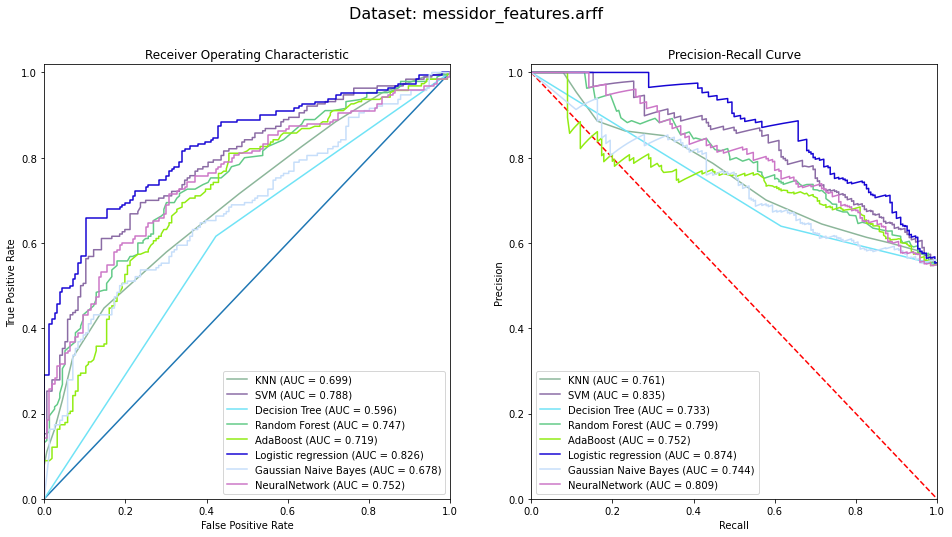

Dataset : default of credit card clients.xls
Class distributions:
0    3915
1    1085
Name: default payment next month, dtype: int64
No question marks found
No question marks found
No default test set, dataset splitted
Encoding X features
Normalized data by scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
Encoding y label values
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...
Training LogisticRegression ...
Training GaussianNaiveBayes ...
Training NeuralNetwork ...


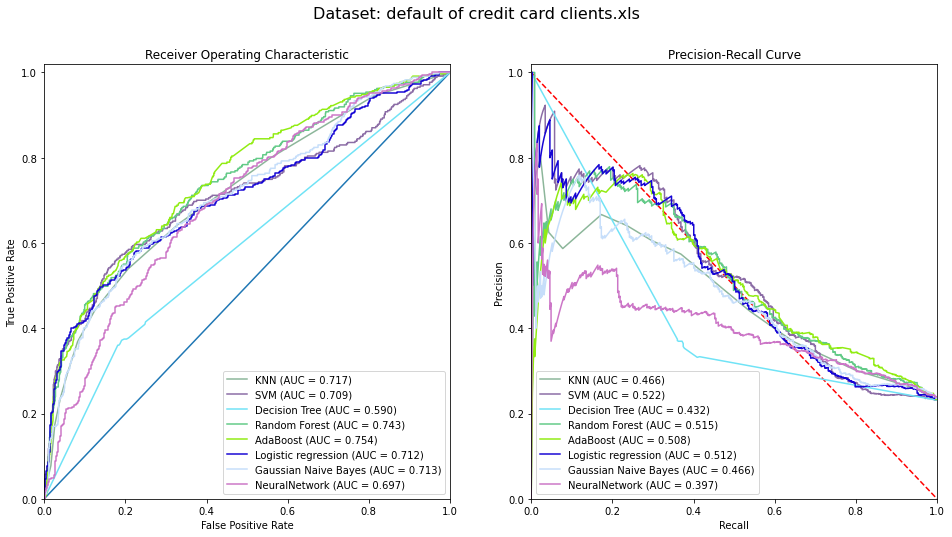

Dataset : breast-cancer-wisconsin.data
Class distributions:
2    444
4    239
Name: 10, dtype: int64
No question marks found
No question marks found
No default test set, dataset splitted
Encoding X features
Normalized data by scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
Encoding y label values
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...
Training LogisticRegression ...
Training GaussianNaiveBayes ...
Training NeuralNetwork ...


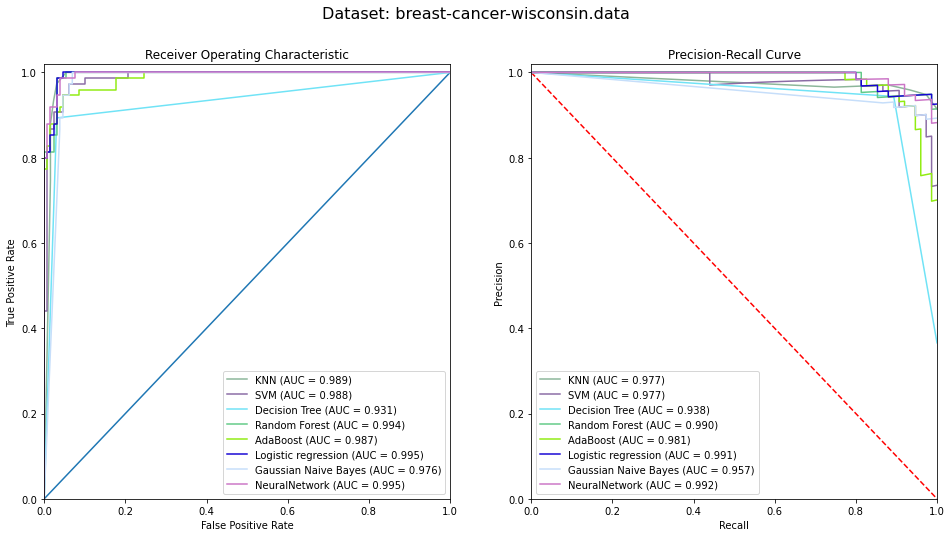

Dataset : wdbc.data
Class distributions:
B    357
M    212
Name: 1, dtype: int64
Replaced all '?' to np.nan
No question marks found
No default test set, dataset splitted
Encoding X features
Normalized data by scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
Encoding y label values
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...
Training LogisticRegression ...
Training GaussianNaiveBayes ...
Training NeuralNetwork ...


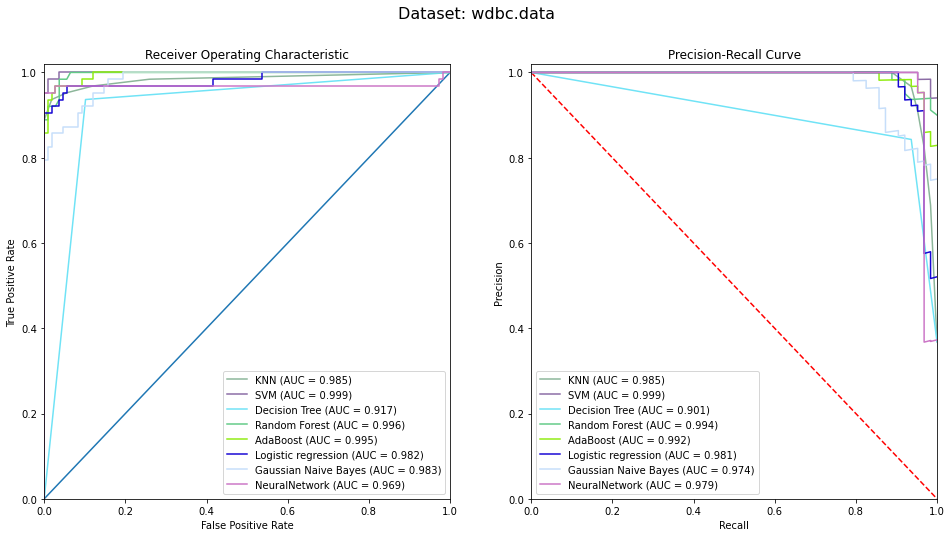

Dataset : wpbc.data
Class distributions:
N    148
R     46
Name: 1, dtype: int64
Replaced all '?' to np.nan
No question marks found
No default test set, dataset splitted
Encoding X features
Normalized data by scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
Encoding y label values
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...
Training LogisticRegression ...
Training GaussianNaiveBayes ...
Training NeuralNetwork ...


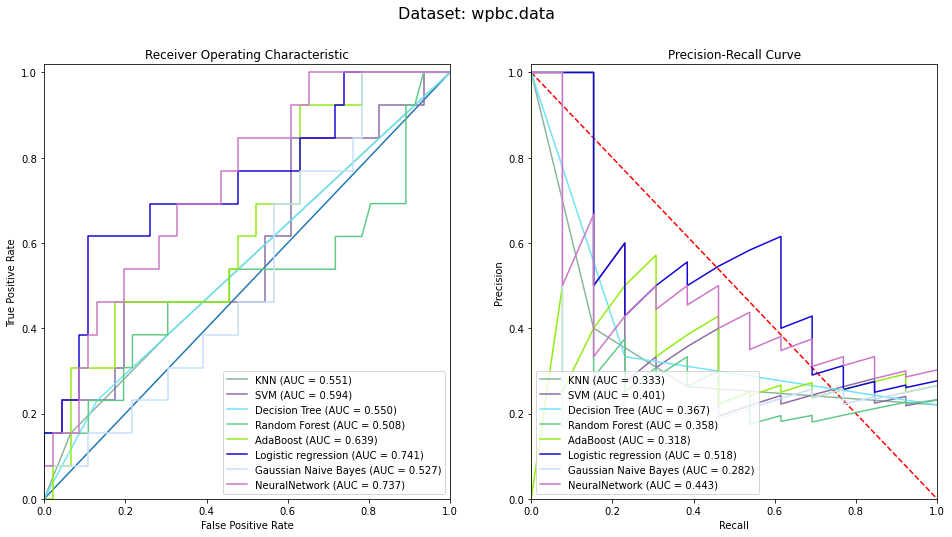

Dataset : australian.dat
Class distributions:
1    468
0    222
Name: 0, dtype: int64
No question marks found
No question marks found
No default test set, dataset splitted
Encoding X features
Normalized data by scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
Encoding y label values
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...
Training LogisticRegression ...
Training GaussianNaiveBayes ...
Training NeuralNetwork ...


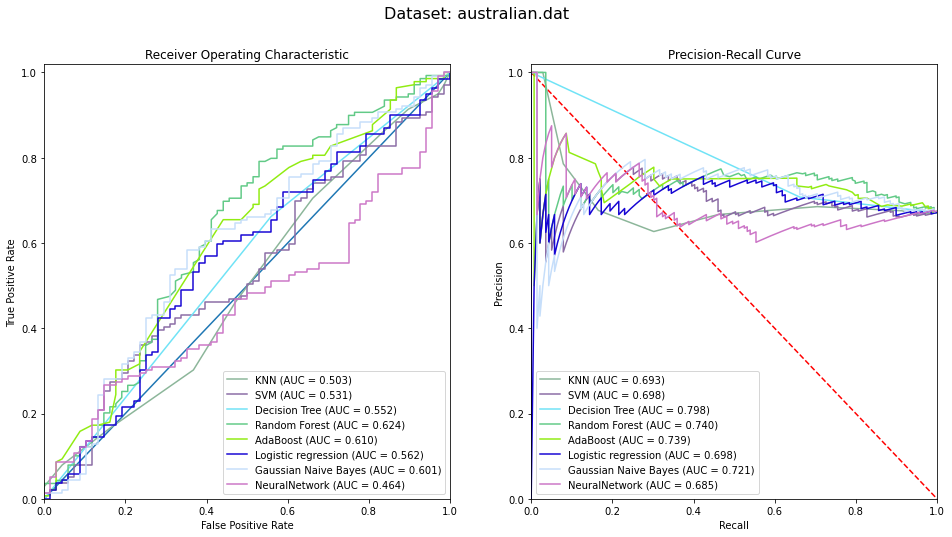

Dataset : german.data-numeric
Class distributions:
1    700
2    300
Name: 24, dtype: int64
No question marks found
No question marks found
No default test set, dataset splitted
Encoding X features
Normalized data by scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
Encoding y label values
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...
Training LogisticRegression ...
Training GaussianNaiveBayes ...
Training NeuralNetwork ...


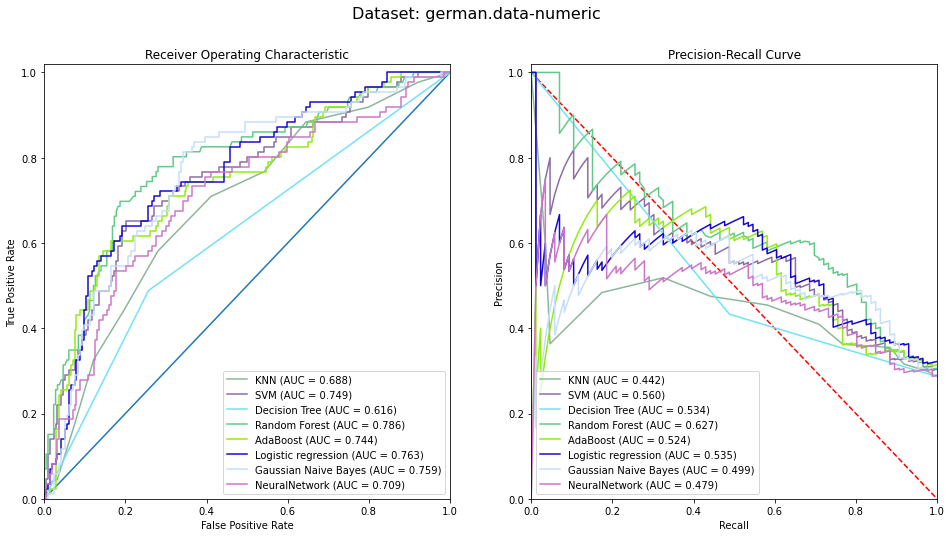

Dataset : Faults.NNA
Class distributions:
33    673
32    402
29    391
28    190
27    158
30     72
31     55
Name: class, dtype: int64
No question marks found
No question marks found
No default test set, dataset splitted
Encoding X features
Normalized data by scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
Encoding y label values
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...
Training LogisticRegression ...
Training GaussianNaiveBayes ...
Training NeuralNetwork ...


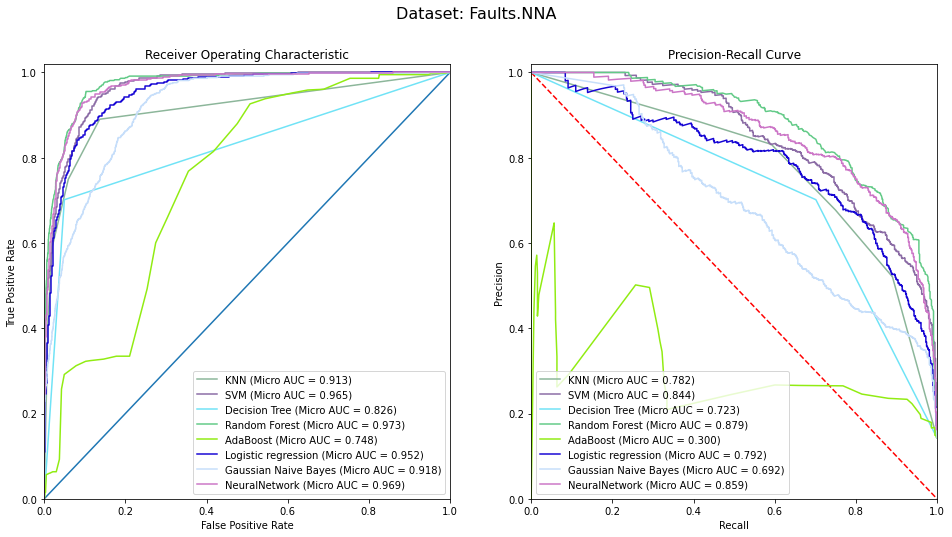

Dataset : adult.data
Class distributions:
<=50K    3777
>50K     1223
Name: 14, dtype: int64
Replaced all '?' to np.nan
Replaced all '?' to np.nan
Loaded given test set
Encoding X features
Normalized data by scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
Encoding y label values
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...
Training LogisticRegression ...
Training GaussianNaiveBayes ...
Training NeuralNetwork ...


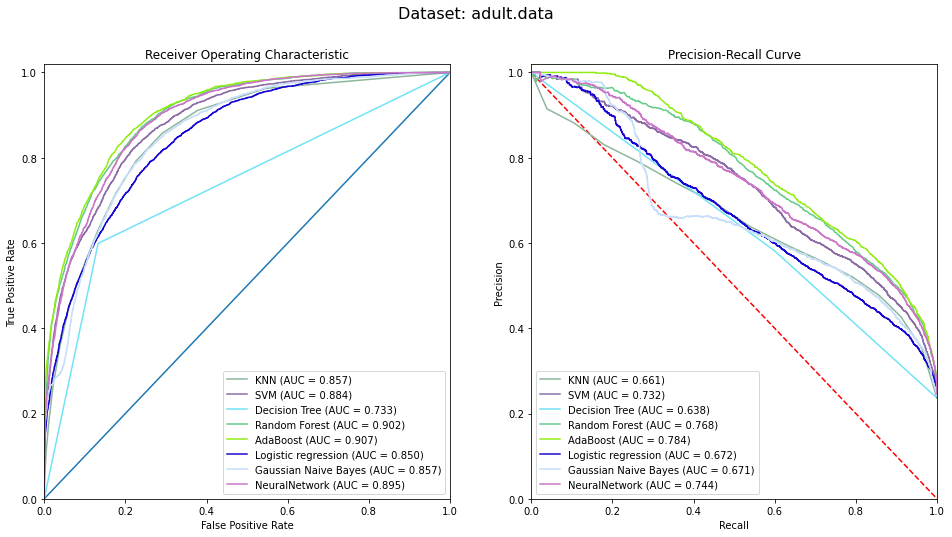

Dataset : yeast.data
Class distributions:
CYT    463
NUC    429
MIT    244
ME3    163
ME2     51
ME1     44
EXC     35
VAC     30
POX     20
ERL      5
Name: 9, dtype: int64
Replaced all '?' to np.nan
No question marks found
No default test set, dataset splitted
Encoding X features
Normalized data by scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
Encoding y label values
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...
Training LogisticRegression ...
Training GaussianNaiveBayes ...
Training NeuralNetwork ...


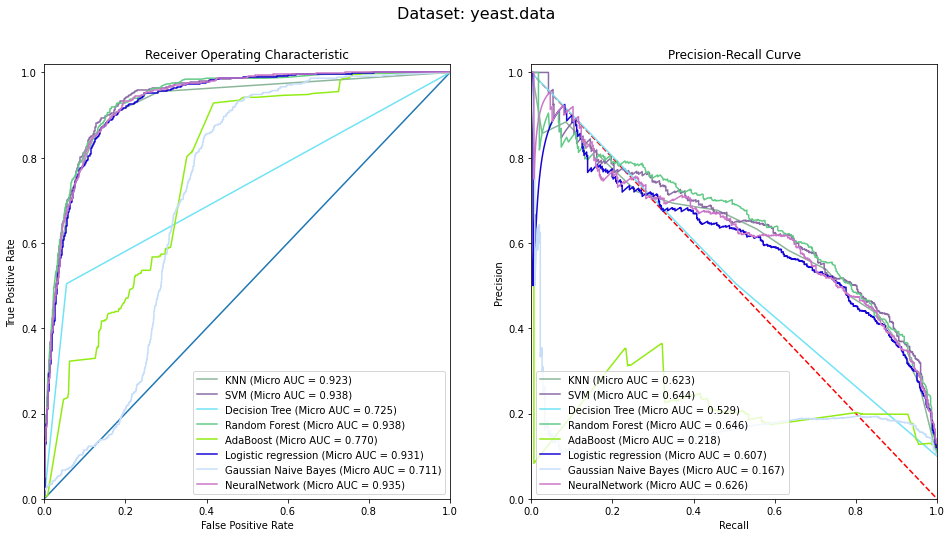

Dataset : ThoraricSurgery.arff
Class distributions:
b'F'    400
b'T'     70
Name: Risk1Yr, dtype: int64
Replaced all '?' to np.nan
No question marks found
No default test set, dataset splitted
Encoding X features
Normalized data by scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
Encoding y label values
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...
Training LogisticRegression ...
Training GaussianNaiveBayes ...
Training NeuralNetwork ...


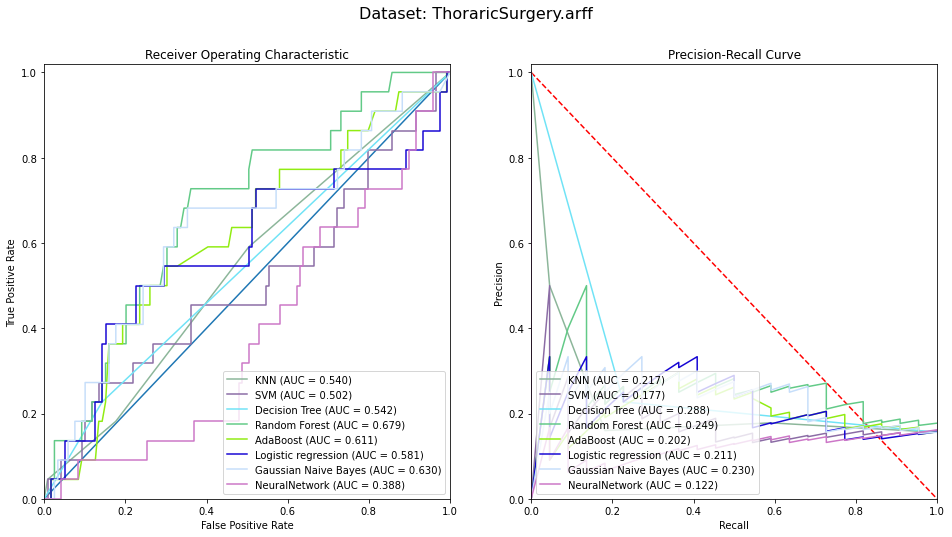

Dataset : seismic-bumps.arff
Class distributions:
b'0'    2414
b'1'     170
Name: class, dtype: int64
Replaced all '?' to np.nan
No question marks found
No default test set, dataset splitted
Encoding X features
Normalized data by scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
Encoding y label values
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...
Training LogisticRegression ...
Training GaussianNaiveBayes ...
Training NeuralNetwork ...


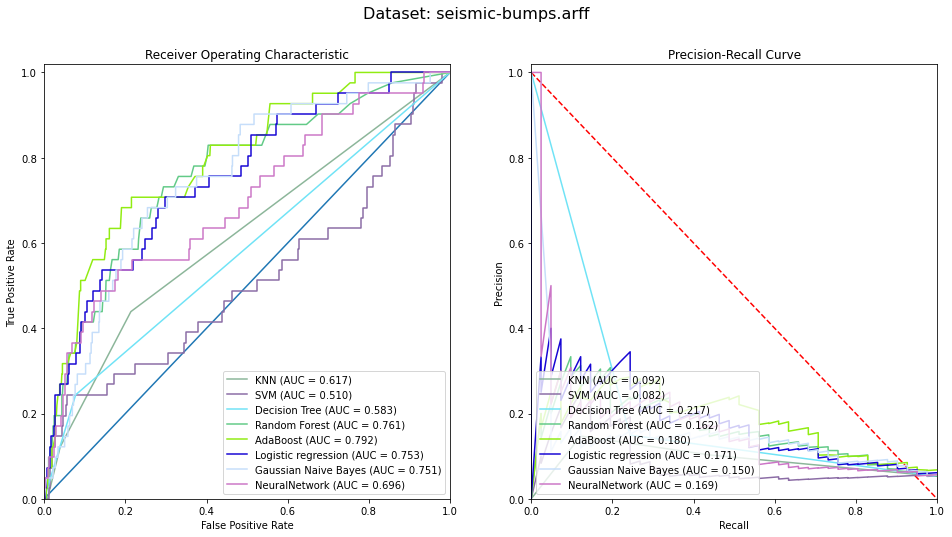

In [25]:
files = [file1,file2,file3,file3_2,file3_3,file4,file5,file6,file7,file8,file9,file10]
dfs = [df1,df2,df3,df3_2,df3_3,df4,df5,df6,df7,df8,df9,df10]
dfs_test = [None,None,None,None,None,None,None,None,df7_test,None,None,None]

clfs_all_roc_scores = dict()
clfs_all_pr_scores = dict()


for file,df,df_test in zip(files,dfs,dfs_test):
    roc_scores, pr_scores = make_classification(file, df, df_test)
    for k,v in roc_scores.items():
        if k not in clfs_all_roc_scores:
            clfs_all_roc_scores[k] = list()
        clfs_all_roc_scores[k].append(v)
    for k,v in pr_scores.items():
        if k not in clfs_all_pr_scores:
            clfs_all_pr_scores[k] = list()
        clfs_all_pr_scores[k].append(v)    

In [26]:
for k,v in clfs_all_roc_scores.items():
    print('%s-roc:'%k,["%.3f"%i for i in v])

KNN-roc: ['0.699', '0.717', '0.989', '0.985', '0.551', '0.503', '0.688', '0.913', '0.857', '0.923', '0.540', '0.617']
SVM-roc: ['0.788', '0.709', '0.988', '0.999', '0.594', '0.531', '0.749', '0.965', '0.884', '0.938', '0.502', '0.510']
Decision Tree-roc: ['0.596', '0.590', '0.931', '0.917', '0.550', '0.552', '0.616', '0.826', '0.733', '0.725', '0.542', '0.583']
Random Forest-roc: ['0.747', '0.743', '0.994', '0.996', '0.508', '0.624', '0.786', '0.973', '0.902', '0.938', '0.679', '0.761']
AdaBoost-roc: ['0.719', '0.754', '0.987', '0.995', '0.639', '0.610', '0.744', '0.748', '0.907', '0.770', '0.611', '0.792']
Logistic regression-roc: ['0.826', '0.712', '0.995', '0.982', '0.741', '0.562', '0.763', '0.952', '0.850', '0.931', '0.581', '0.753']
Gaussian Naive Bayes-roc: ['0.678', '0.713', '0.976', '0.983', '0.527', '0.601', '0.759', '0.918', '0.857', '0.711', '0.630', '0.751']
NeuralNetwork-roc: ['0.752', '0.697', '0.995', '0.969', '0.737', '0.464', '0.709', '0.969', '0.895', '0.935', '0.388

In [27]:
for k,v in clfs_all_pr_scores.items():
    print('%s-pr:'%k,["%.3f"%i for i in v])

KNN-pr: ['0.761', '0.466', '0.977', '0.985', '0.333', '0.693', '0.442', '0.782', '0.661', '0.623', '0.217', '0.092']
SVM-pr: ['0.835', '0.522', '0.977', '0.999', '0.401', '0.698', '0.560', '0.844', '0.732', '0.644', '0.177', '0.082']
Decision Tree-pr: ['0.733', '0.432', '0.938', '0.901', '0.367', '0.798', '0.534', '0.723', '0.638', '0.529', '0.288', '0.217']
Random Forest-pr: ['0.799', '0.515', '0.990', '0.994', '0.358', '0.740', '0.627', '0.879', '0.768', '0.646', '0.249', '0.162']
AdaBoost-pr: ['0.752', '0.508', '0.981', '0.992', '0.318', '0.739', '0.524', '0.300', '0.784', '0.218', '0.202', '0.180']
Logistic regression-pr: ['0.874', '0.512', '0.991', '0.981', '0.518', '0.698', '0.535', '0.792', '0.672', '0.607', '0.211', '0.171']
Gaussian Naive Bayes-pr: ['0.744', '0.466', '0.957', '0.974', '0.282', '0.721', '0.499', '0.692', '0.671', '0.167', '0.230', '0.150']
NeuralNetwork-pr: ['0.809', '0.397', '0.992', '0.979', '0.443', '0.685', '0.479', '0.859', '0.744', '0.626', '0.122', '0.16

In [28]:
for k,v in clfs_all_roc_scores.items():
    print('%s avg roc_auc: %.2f, avg pr_auc: %.2f'%(k,np.mean(v),np.mean(clfs_all_pr_scores[k])))

KNN avg roc_auc: 0.75, avg pr_auc: 0.59
SVM avg roc_auc: 0.76, avg pr_auc: 0.62
Decision Tree avg roc_auc: 0.68, avg pr_auc: 0.59
Random Forest avg roc_auc: 0.80, avg pr_auc: 0.64
AdaBoost avg roc_auc: 0.77, avg pr_auc: 0.54
Logistic regression avg roc_auc: 0.80, avg pr_auc: 0.63
Gaussian Naive Bayes avg roc_auc: 0.76, avg pr_auc: 0.55
NeuralNetwork avg roc_auc: 0.77, avg pr_auc: 0.61
